In [1]:
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import load_iris
import sys; sys.path.append('../rrr')
from multilayer_perceptron import *
from figure_grid import *
from local_linear_explanation import *
import numpy as np
import iris_cancer
from sklearn.model_selection import train_test_split
import itertools

# Iris-Cancer

To provide an example of input gradients on a slightly more real-world dataset (also not an image or text dataset), let's look at the [Iris Dataset](https://archive.ics.uci.edu/ml/datasets/Iris), and then let's combine it with the [Wisconsin Breast Cancer Dataset](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+(Diagnostic)) to show how input gradient explanations can help resolve ambiguities.

## Visualizing Iris Explanations

First let's just train a model to classify iris, and see if we can visualize what input gradients mean for that model (since iris is fairly low-dimensional).

In [3]:
iris = load_iris()

In [4]:
iris_X, iris_Xt, iris_y, iris_yt = train_test_split(iris.data, iris.target, test_size=0.4, random_state=0)

In [8]:
grads0 = mlp.input_gradients(iris_X, 0)
grads1 = mlp.input_gradients(iris_X, 1)
grads2 = mlp.input_gradients(iris_X, 2)
gradsp = mlp.input_gradients(iris_X)

In [9]:
X0 = iris.data[np.argwhere(iris.target==0)][:,0]
X1 = iris.data[np.argwhere(iris.target==1)][:,0]
X2 = iris.data[np.argwhere(iris.target==2)][:,0]

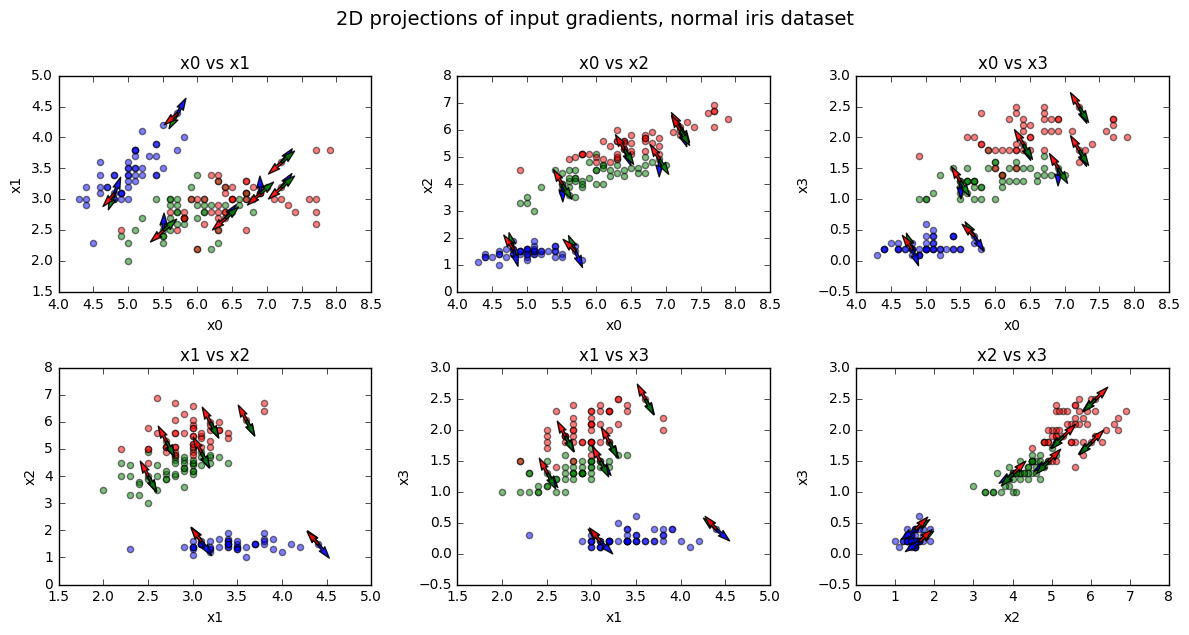

In [26]:
def plot_iris_arrows(i,j, pts=[1,13,10,5,14,20,7]):
  plt.title('x{} vs x{}'.format(i,j))
  plt.xlabel('x{}'.format(i))
  plt.ylabel('x{}'.format(j))
  plt.scatter(X0[:,i], X0[:,j], c='blue', alpha=0.5)
  plt.scatter(X1[:,i], X1[:,j], c='green', alpha=0.5)
  plt.scatter(X2[:,i], X2[:,j], c='red', alpha=0.5)

  def quiv(k):
    kwargs = {'lw':1,'alpha':0.9,'units':'dots'}
    plt.quiver(iris_X[k,i], iris_X[k,j], grads0[k,i], grads0[k,j], color='blue', **kwargs)
    plt.quiver(iris_X[k,i], iris_X[k,j], grads1[k,i], grads1[k,j], color='green', **kwargs)
    plt.quiver(iris_X[k,i], iris_X[k,j], grads2[k,i], grads2[k,j], color='red', **kwargs)
  
  for pt in pts:
    quiv(pt)


with figure_grid(2,3) as g:
  g.title('2D projections of input gradients, normal iris dataset')
  for ax, (i, j) in zip(g.each_subplot(), itertools.combinations([0,1,2,3], 2)):
    plot_iris_arrows(i,j)

Input gradients for the probabilities of each class (color-coded) are plotted separately (note the arrow sizes don't provide a sense of the relative magnitudes of each gradient, just the dimension). For the most part, these gradients indicate that the way to increase the probability of a given class is to move in the direction of that class's cluster, though in the $x_0$ vs $x_1$ case, where the red and green-coded classes are intermingled, there isn't a meaningful cluster and the gradients point in random directions.

So basically, input gradients make sense here, and even if we only explained a single example with no knowledge of the dataset, we would be able to gain a lot of information about where the clusters lie.

## (Decoy) Iris-Cancer

Now let's try mashing together the iris and cancer datasets. They have different numbers of features (4 for iris, 30 for cancer), different numbers of classes (3 for iris and 2 for cancer), and finally different numbers of examples (50 per class for iris, many more for cancer). To make everything line up, we'll concatenate the features but only take 100 total examples (50+50 for the two least separable iris classes, and the first 100 breast cancer examples). This splitting occurs in `rrr/iris_cancer.py`.

To make things difficult for our classifier, in our training set, we'll include the somewhat-separable iris features, but in our test set, we'll zero them out.

In [3]:
normal_Xtr_accuracies = []
normal_Xt_accuracies = []
normal_iris_usages = []

noiris_Xtr_accuracies = []
noiris_Xt_accuracies = []
noiris_iris_usages = []

for i in range(50):
  X, Xtr, Xt, y, yt = iris_cancer.generate_dataset() # fully regenerates the dataset, random split
  A = np.zeros_like(X).astype(bool)
  A[:, :4] = True

  mlp_normal = MultilayerPerceptron()
  mlp_normal.fit(X, y, num_epochs=200)
  
  mlp_noiris = MultilayerPerceptron(l2_grads=1000)
  mlp_noiris.fit(X, y, A, num_epochs=200)
  
  normal_Xtr_accuracies.append(mlp_normal.score(Xtr, yt))
  normal_Xt_accuracies.append(mlp_normal.score(Xt, yt))
  normal_iris_usages.append(iris_cancer.iris_usage(mlp_normal, Xtr))
  
  noiris_Xtr_accuracies.append(mlp_noiris.score(Xtr, yt))
  noiris_Xt_accuracies.append(mlp_noiris.score(Xt, yt))
  noiris_iris_usages.append(iris_cancer.iris_usage(mlp_noiris, Xtr))

In [65]:
print(np.mean(noiris_Xt_accuracies))
print(np.mean(noiris_Xtr_accuracies))

0.907878787879
0.907878787879


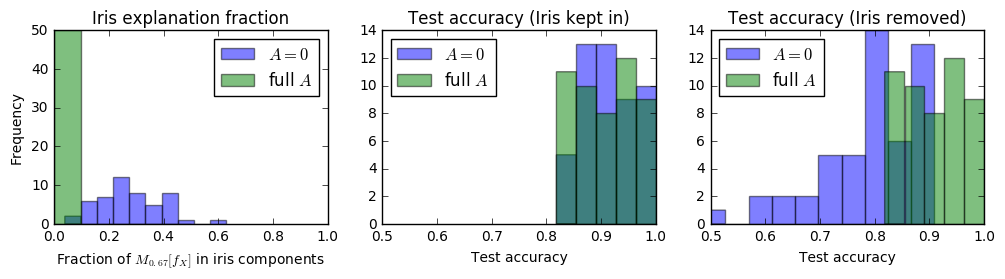

In [35]:
plt.figure(figsize=(12,2.5))
plt.subplot(131)
plt.title('Iris explanation fraction')
plt.hist(normal_iris_usages, label=r'$A=0$', alpha=0.5)
plt.hist(noiris_iris_usages, label=r'full $A$', alpha=0.5)
plt.legend(loc='best')
plt.xlim(0, 1)
plt.ylabel('Frequency')
plt.xlabel('Fraction of $M_{0.67}[f_X]$ in iris components')

plt.subplot(132)
plt.title('Test accuracy (Iris kept in)')
plt.xlim(0.5,1)
plt.hist(normal_Xtr_accuracies, label=r'$A=0$', alpha=0.5, bins=5)
plt.hist(noiris_Xtr_accuracies, label=r'full $A$', alpha=0.5, bins=5)
plt.legend(loc='best')
plt.xlabel('Test accuracy')
             
plt.subplot(133)
plt.title('Test accuracy (Iris removed)')
plt.xlim(0.5,1)
plt.hist(normal_Xt_accuracies, label=r'$A=0$', alpha=0.5, bins=10)
plt.hist(noiris_Xt_accuracies, label=r'full $A$', alpha=0.5, bins=5)
plt.legend(loc='best')
plt.xlabel('Test accuracy')
             
plt.show()

It's a bit random, which isn't necessarily that surprising with 60 training examples and 40 test examples. Still, test accuracy (when we remove iris features) is reliably higher when we penalize the model for having high gradient values in iris features.

## Find-another-explanation

Let's try our find-another-explanation scheme on this dataset too, then plot results:

In [68]:
def iris_cancer_faes():
  X, Xtr, Xt, y, yt = iris_cancer.generate_dataset()
  A = np.zeros_like(X).astype(bool)
  faes = []

  for i in range(5):
    mlp = MultilayerPerceptron(l2_grads=1000)
    mlp.fit(X, y, A, num_epochs=200)
    faes.append((mlp, mlp.score(Xt,yt), mlp.score(X,y), iris_cancer.iris_usage(mlp, X)))
    A += mlp.largest_gradient_mask(X)

  return faes

fae_groups = [iris_cancer_faes() for _ in range(50)]

In [69]:
testscore_means = [np.mean([fae_group[i][1] for fae_group in fae_groups]) for i in range(len(fae_groups[0]))]
trainscore_means = [np.mean([fae_group[i][2] for fae_group in fae_groups]) for i in range(len(fae_groups[0]))]
testscore_errs = [np.std([fae_group[i][1] for fae_group in fae_groups]) for i in range(len(fae_groups[0]))]
trainscore_errs = [np.std([fae_group[i][2] for fae_group in fae_groups]) for i in range(len(fae_groups[0]))]
iris_usage_means = [np.mean([fae_group[i][3] for fae_group in fae_groups]) for i in range(len(fae_groups[0]))]

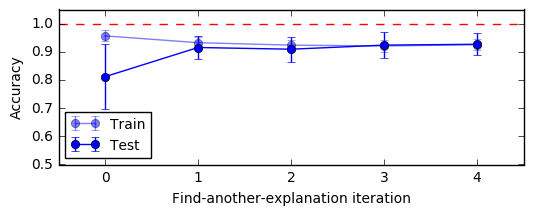

In [70]:
plt.figure(figsize=(6,2))
plt.axhline(1, ls='--', color='red')
plt.errorbar(list(range(len(trainscores))), trainscore_means, yerr=trainscore_errs, marker='o', alpha=0.5, label='Train')
plt.errorbar(list(range(len(testscores))), testscore_means, yerr=testscore_errs, marker='o', label='Test', c='blue')
plt.legend(loc='best', fontsize=10)
plt.ylim(0.5,1.05)
plt.xlim(-0.5, 4.5)
plt.xlabel('Find-another-explanation iteration')
plt.ylabel('Accuracy')
plt.show()

In [71]:
iris_usage_means

[0.27813926419479118,
 0.15651711023358289,
 0.083399773314089043,
 0.017479624372572236,
 0.035181563747461106]

So our results are again somewhat random, but the overall trend is for test accuracy to increase after the first find-another-explanation iteration (and iris usage to go down).

Let's plot these results together:

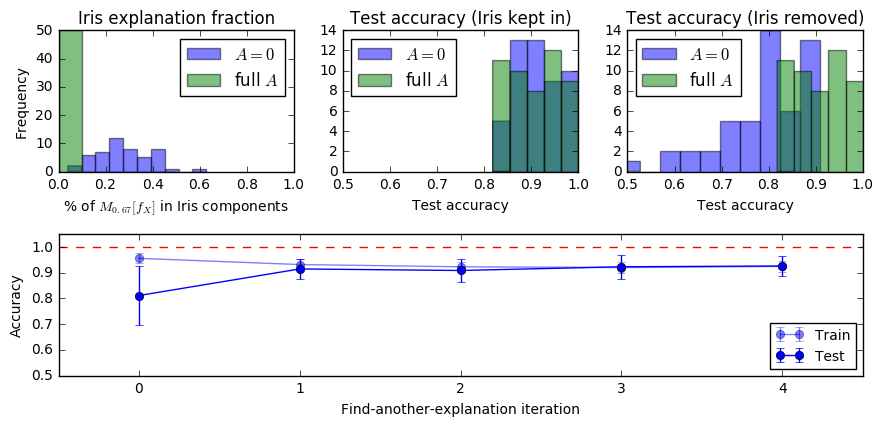

In [72]:
gridsize = (3,3)
plt.figure(figsize=(9,6))

plt.subplot2grid(gridsize, (0,0))
plt.title('Iris explanation fraction')
plt.hist(normal_iris_usages, label=r'$A=0$', alpha=0.5)
plt.hist(noiris_iris_usages, label=r'full $A$', alpha=0.5)
plt.legend(loc='best')
plt.xlim(0, 1)
plt.ylabel('Frequency')
plt.xlabel('% of $M_{0.67}[f_X]$ in Iris components')

plt.subplot2grid(gridsize, (0,1))
plt.title('Test accuracy (Iris kept in)')
plt.xlim(0.5,1)
plt.hist(normal_Xtr_accuracies, label=r'$A=0$', alpha=0.5, bins=5)
plt.hist(noiris_Xtr_accuracies, label=r'full $A$', alpha=0.5, bins=5)
plt.legend(loc='best')
plt.xlabel('Test accuracy')

plt.subplot2grid(gridsize, (0,2))
plt.title('Test accuracy (Iris removed)')
plt.xlim(0.5,1)
plt.hist(normal_Xt_accuracies, label=r'$A=0$', alpha=0.5, bins=10)
plt.hist(noiris_Xt_accuracies, label=r'full $A$', alpha=0.5, bins=5)
plt.legend(loc='best')
plt.xlabel('Test accuracy')

plt.subplot2grid(gridsize, (1,0), colspan=3)
plt.axhline(1, ls='--', color='red')
plt.errorbar(list(range(len(trainscores))), trainscore_means, yerr=trainscore_errs, marker='o', alpha=0.5, label='Train')
plt.errorbar(list(range(len(testscores))), testscore_means, yerr=testscore_errs, marker='o', label='Test', c='blue')
plt.legend(loc='best', fontsize=10)
plt.ylim(0.5,1.05)
plt.xlim(-0.5, 4.5)
plt.xlabel('Find-another-explanation iteration')
plt.ylabel('Accuracy')
plt.tight_layout()
plt.show()